# Deployment Track Report

* Name: Ziyi Liang
* Net-ID: zl5604

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
from IPython import display
import tensorflow.keras.backend as K
import tensorflow as tf

## Models

### Previous Model

* Optimizing metrics

    The accuracy of the prevous model on the evaluation set is `0.7622`. The confusion matrix shows that it is bad at predicting bread, dairy product, dessert and sea food. Also the prediction of egg and fried food are a bit under average accuracy.

![title](prev_confusion_matrix.png)

* Oepration metrics

    The typical response time is `1.12 second` and transcation rate is `7.35%`. The disk space taken by this model is `9.27 MB`, and memory used is `357 MiB`.

    - Siege command output:
        ```json
        {       "transactions":                          138,
                "availability":                        11.78,
                "elapsed_time":                        18.77,
                "data_transferred":                     0.00,
                "response_time":                        1.12,
                "transaction_rate":                     7.35,
                "throughput":                           0.00,
                "concurrency":                          8.23,
                "successful_transactions":               138,
                "failed_transactions":                  1033,
                "longest_transaction":                  1.60,
                "shortest_transaction":                 0.55
        }
        ```
    - CPU and memory usage:
        ```bash
        shigi@node-0:~$ kubectl top pod
        NAME                          CPU(cores)   MEMORY(bytes)
        ml-kube-app-bb795fd87-kpr5v   37m          357Mi
        ```

### Submit Model 1 - <b>MobileNet

* Optimizing metrics

    The accuracy of the prevous model on the evaluation set is `0.8742`. The confusion matrix shows that the model predict every class with at least 80% accuracy except diary product (`78%`). The model seems occasionallly mis-classifies dessert as diary product. (`11%`)

![](mobilenet_confusion_matrix.png)

![](old_model_prediction.png)

* Oepration metrics

    The typical response time is `1.10 second` and transcation rate is `7.32 %`. The disk space taken by this model is `20.7 MB`, and memory used is `317 MiB`.

* I used the built-in MobileNet. The model has 3,228,864 paramemters. This is a classic neural network capable of performing object classification. As the first generation of MobileNet, it has relatively simple network structure, so it is easier for me to learn the structure, and train annd fine-tune on this model.
* The augmentations used are the default ones provided by Professor Fund. (Explanation for these augmentations quoted from docstring of ` tf.keras.preprocessing.image.ImageDataGenerator`)
    * `rescale=1.0/255`: Rescale all pixels into [0, 1] range;
    * `rotation_range=1`: degree range for random rotations;
	* `zoom_range=0.1`：range for random zoom;
	* `width_shift_range=0.1`：fraction of total width shifted horizontally;
	* `height_shift_range=0.1`：fraction of total height shifted vertically;
	* `shear_range=0.1`：the intensity of image being sheared;
	* `horizontal_flip=True`：image is filpped horizontally randomly;
	* `fill_mode="nearest"`: points outside the boundaries of the input are filled with nearest mode;
* I trained the classification head 35 epochs, with Adam optimizer, learning rate of 0.001, amd batch size of 32. The validation accuracy at the end of this training stage is 0.8318.
* There are three stages of un-freezing:
	1. Last 7 layers un-frozen: 
		- The last deepwise convolution layer is included;
		- epoch: 28, optimizer: Adam, learning rate: `1e-05`, batch size: `32`, validation accuracy: `0.8370`;
	2. Last 14 layers un-frozen:
		- The last two deepwise convolution layer are included;
		- epoch: 30, optimizer: Adam, learning rate: `5e-06`, batch size: `32`, validation accuracy: `0.8516`;
	3. Last 20 layers un-frozen:
		- The last three deepwise convolution layers are included;
		- epoch: 8, optimizer: Adam, learning rate: `2.5e-06`, batch size: `32`, validation accuracy: `0.8513`;
	Since the third stage of un-freezing has no improvement in accucary, the final model is the second stage model (last 14 layers un-frozen)
* The final accuracy is `0.8742`
* My model correctly predict the calss of my custom test image.
* To increase accuracy, I tried to unfreeze more layers, which does not affect response time.  

![](mobilenet_structure.png)<br>
<a herf=https://arxiv.org/pdf/1704.04861.pdf>MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications</a>

![](mobilenet_prediction.png)

### Submit model 2 - <b>Inception Resnet v2

* Optimizing metrics
    Inception Resnet v2 is an advanced neural network combining Inception (GoogLeNet) and ResNet. Generally, it has better performance on object classification than MobileNet.
    The accuracy of the prevous model on the evaluation set is `0.8963`. The confusion matrix shows that the model predict every class with at least `85%` accuracy except diary product (`80%`). The model seems occasionallly mis-classifies dessert as diary product. (`11%`)

<a herf=https://arxiv.org/pdf/1602.07261v2.pdf>(Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning)
![](googlenet_confunsion_matrix.png)

![](googlenet_prediction.png)

* Oepration metrics

    The typical response time is `1.67 second` and transcation rate is `5.10%`. The disk space taken by this model is `248 MB`, and memory used is `638 MiB`.

* I used the Inception Resnet v2. The model has 54,336,736 paramemters.
* The augmentations used are the default ones provided by Professor Fund, 
	Plus three additional augmentations: (Explanation for these augmentations quoted from docstring of ` tf.keras.preprocessing.image.ImageDataGenerator`)
    * `rescale=1.0/255`: Rescale all pixels into [0, 1] range;
    * `rotation_range=1`: degree range for random rotations;
	* `zoom_range=0.1`：range for random zoom;
	* `width_shift_range=0.1`：fraction of total width shifted horizontally;
	* `height_shift_range=0.1`：fraction of total height shifted vertically;
	* `shear_range=0.1`：the intensity of image being sheared;
	* `horizontal_flip=True`：image is filpped horizontally randomly;
	* `fill_mode="nearest"`: points outside the boundaries of the input are filled with nearest mode;
	* `rotation_range=90`: the image is rotated randomly up to 90 degree;
	* `brightness_range=(0.8, 1.2)`: the RGB value is multiplied by value randomly selected from the range;
	* `channel_shift_range=0.1`: the channel is randomly shifted.

* I trained the classification head 45 epochs, with Adam optimizer, learning rate of 0.001, amd batch size of 32. The validation accuracy at the end of this training stage is 0.8373.
* There is one stage of un-freezing:
	1. Last 19 layers un-frozen: 
		- The last 19 to 5 layers are the last residual inception block. Unfreezing this block helps the model learn more detailed features;
		- epoch: `34`, optimizer: `Adam`, learning rate: `2e-05`, batch size: `16`, validation accuracy: `0.8778`
* The final accuracy is `0.8963`
* My model does not predict the calss of my custom test image correctly.
* To increase accuracy, I unfreeze the last 19 layers of the model, which will not affect the response time.

### Model Summary

In [69]:
df = pd.DataFrame([
    [0.7622, 357, 7.35, 1.12, 2272075], 
    [0.8742, 317, 7.32, 1.10, 3228864],
    [0.8963, 638, 5.10,1.67, 54336736]],
    columns=["Accuracy", "Memory Usage", "Transaction rate", "Response time", "Parameters"], 
    index=["Previous model", "MobileNet", "Inception Resnetv2"])
print(df)

                    Accuracy  Memory Usage  Transaction rate  Response time  \
Previous model        0.7622           357              7.35           1.12   
MobileNet             0.8742           317              7.32           1.10   
Inception Resnetv2    0.8963           638              5.10           1.67   

                    Parameters  
Previous model         2272075  
MobileNet              3228864  
Inception Resnetv2    54336736  


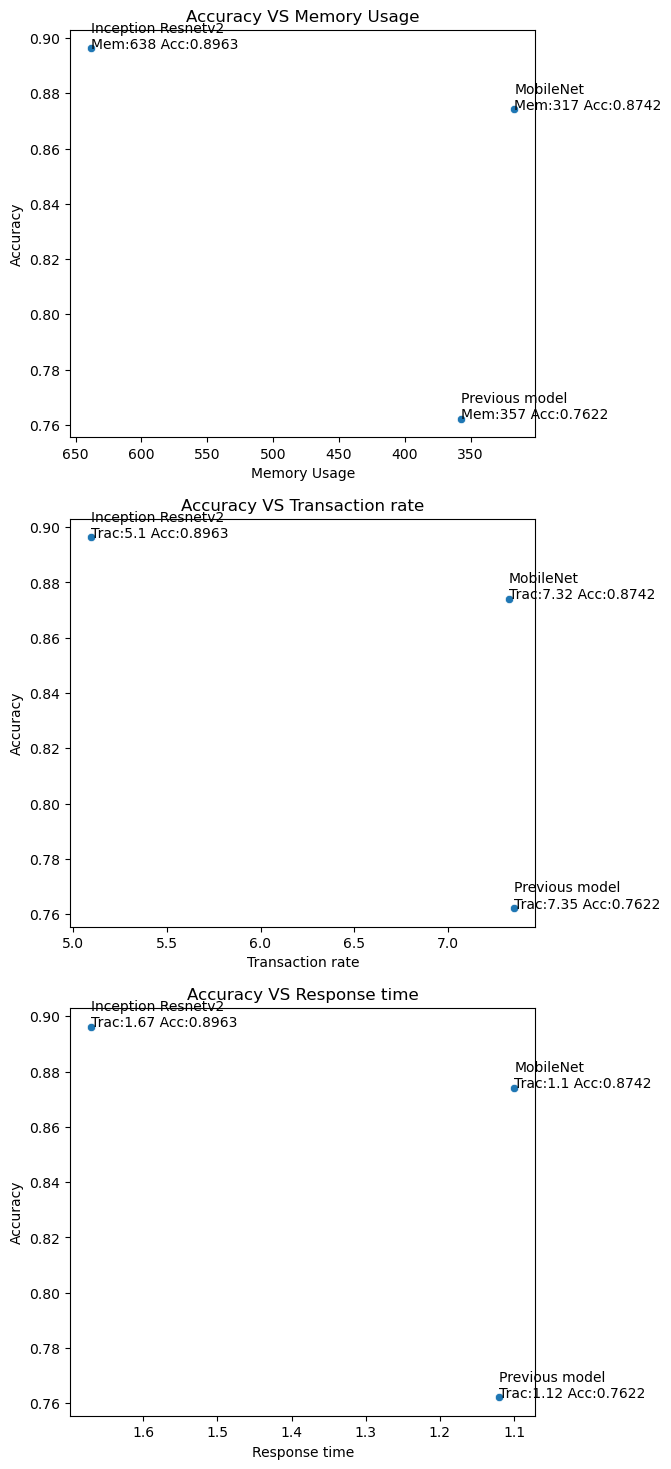

In [65]:
plt.figure(figsize=(6, 18))

plt.subplot(3,1,1)
plt.title(f"Accuracy VS Memory Usage")
ax = sns.scatterplot(x=df["Memory Usage"], y=df['Accuracy'])
ax.invert_xaxis()
for i in range(len(df.index)):
    dot_text = f"{df.index[i]}\nMem:{df['Memory Usage'][i]} Acc:{df['Accuracy'][i]}"
    ax.text(df["Memory Usage"][i], df['Accuracy'][i], dot_text)

plt.subplot(3,1,2)
plt.title(f"Accuracy VS Transaction rate")
ax = sns.scatterplot(x=df["Transaction rate"], y=df['Accuracy'])
for i in range(len(df.index)):
    dot_text = f"{df.index[i]}\nTrac:{df['Transaction rate'][i]} Acc:{df['Accuracy'][i]}"
    ax.text(df["Transaction rate"][i], df['Accuracy'][i], dot_text)

plt.subplot(3,1,3)
plt.title(f"Accuracy VS Response time")
ax = sns.scatterplot(x=df["Response time"], y=df['Accuracy'])
ax.invert_xaxis()
for i in range(len(df.index)):
    dot_text = f"{df.index[i]}\nTrac:{df['Response time'][i]} Acc:{df['Accuracy'][i]}"
    ax.text(df["Response time"][i], df['Accuracy'][i], dot_text)        

## Deployments

## Evaluation